In [1]:
'''
Algoritmo A*
1) Cree un grafo de búsqueda G y una lista ABIERTA y ponga a s en cada uno de ellos.
2) Cree una lista vacía CERRADA.
3) Si ABIERTA está vacía retorne con Falla.
4) Remueva el 1er nodo = n de ABIERTA y colóquela en CERRADA.
5) Si n = Meta retorne con Éxito.
6) Genere los M sucesores de n que no sean sus ancestros y póngalos en G.
7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
    agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
    si es un camino más corto.
8) Reordene ABIERTA.
9) Vaya al punto 3

'''
import networkx as nx
import matplotlib as plt
import numpy as np
import random
from datetime import datetime
from utils import hierarchy_pos2

def costoDeSaM(grafoG,mat_costCiu,nodo_s,nodo_m):
    # se calcula el costo desde el inicio S hasta M con M todos los nodos no ABIERTOS
    Gn = 0
    aux = nodo_m
    while (aux != nodo_s):
        vecinos = grafoG.neighbors(aux)
        padres = []
        for vecino in vecinos:
            if not vecino == None:
                padres.append((aux,vecino))
        for a in padres:
            if a[0] == aux:
                # el nodo_m(aux) tiene padre
                Gn += costoDeNaM(mat_costCiu,a[0],a[1])
                # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                aux = a[1]
                break
    return Gn

def costoDeNaM(mat_costCiu,nodo_n,nodo_m):
    nro_ciudadN = int(nodo_n[1].split('ciudad')[1])
    nro_ciudadM = int(nodo_m[1].split('ciudad')[1])
    return mat_costCiu[nro_ciudadN-1][nro_ciudadM-1]

def calcularHn(grafoG,mat_costCiu,vec_costCiu,nodo_s,nodo_m):
    # se estima el costo desde M hasta el final con M todos los nodos no ABIERTOS
    vec_aux = [a for a in vec_costCiu] # vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
    aux = nodo_m
    nivel = 0 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
    while (aux != nodo_s):
        vecinos = grafoG.neighbors(aux)
        padres = []
        for vecino in vecinos:
            if not vecino == None:
                padres.append((aux,vecino))
        for a in padres:
            if a[0] == aux:
                # el nodo_m(aux) tiene padre
                # se le quita el costo del recorrido desde nodo_m a su padre
                vec_aux.remove(costoDeNaM(mat_costCiu,a[0],a[1]))
                nivel += 1
                # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                aux = a[1]
                break

    # se ordena ascendentemente el vector de costos de todos los recorridos
    vec_aux.sort(reverse=False)
    # se toman los primeros (5-nivel) valores y se los sumariza en Hn
    Hn = 0
    for a in (vec_aux[:len(mat_costCiu[0])-nivel]): #len(mat_costCiu[0]) es la cantidad de ciudades ya que representa la cantidad de columnas de la matriz
        Hn += a
    return Hn

def agregarCiudadesDesdeN(id_autoinc, grafoG, nodo_n, ciudades_a_agregar):
    edges = []
    sucesores = []
    for a in ciudades_a_agregar:
        sucesores.append((id_autoinc,a))
        edges.append([nodo_n,sucesores[-1:][0]])
        id_autoinc += 1

    grafoG.add_edges_from(edges)
    return id_autoinc, grafoG, sucesores

def leerArchConf(archivo):
    arch = open(archivo)
    cantCiu = int(arch.readline().split(';')[0])
    vec_costCiu = [int(a) for a in arch.readline().split(';') if a != '\n']
    vecmat_costCiu = []

    vec_costCiu_aux = [a for a in vec_costCiu]
    for a in range(cantCiu):
        #aux = cantCiu + cantCiu*(a-1)
        for c in range(a+1):
            vecmat_costCiu.append(0)
        for b in range(cantCiu-a-1):
            vecmat_costCiu.append(vec_costCiu_aux[0])
            vec_costCiu_aux = vec_costCiu_aux[1:]

    for a in range(cantCiu):
        for b in range(cantCiu):
            if b < a:
                # si la columna es menor a la fila, se copia el valor de su opuesto
                vecmat_costCiu[cantCiu*a+b] = vecmat_costCiu[cantCiu*b+a]

    # se termina de componer la matriz
    mat_costCiu = []
    for a in range(cantCiu):
        mat_costCiu.append(vecmat_costCiu[:cantCiu])
        vecmat_costCiu = vecmat_costCiu[cantCiu:]

    return cantCiu, vec_costCiu, mat_costCiu

def procesar_Aestrella(archivo):
    '''
    1er test, sacado de TSP/TSP_IN_01.txt
    cantCiu = 5
    vec_costCiu = [5,15,17,7,6,19,20,7,21,5]
    mat_costCiu = [
        [ 0, 5,15,17, 7],
        [ 5, 0, 6,19,20],
        [15, 6, 0, 7,21],
        [17,19, 7, 0, 5],
        [ 7,20,21, 5, 0]
    ]
    '''
    # 2do test: sacado del archivo de configuracion utilizando la funcion para tal fin
    cantCiu, vec_costCiu, mat_costCiu = leerArchConf(archivo)
    # TODO: hacer una función por arriba de leerArchConf (y por arriba de todo el proceso) para ejecutar el algoritmo para todos los archivos (o los que se sepa den bien, de la carpeta TSP)
    # estaría bueno que los resultados se saquen a un archivo con los datos de:
    '''
    strCamino es un string con el camino encontrado, de la forma "1;2;3;4;5;1;"
    CT es el costo total del camino encontrado.
    NA es la cantidad de nodos abiertos durante el proceso.
    strTiempoEj es un string con el tiempo de ejecución.
    '''

    # se calcula la fecha y hora antes de procesar
    antes = datetime.now()

    nodos = [(a,"ciudad{}".format(a)) for a in range(1,cantCiu+1)]
    id_autoinc = cantCiu + 1 #id_autoinc lo uso como identificador de nodo

    ## Modelo mi algoritmo A* de forma tal que cada nodo del grafo es una ciudad
    ## la ciudad de inicio y de fin será la 1 pero terminará habiendo recorrido todas las ciudades
    ## nota: el grafo no admite nodos iguales para lo cual diseño cada nodo (ciudad) de forma unívoca con un ID y el nombre de la ciudad (ej: 'ciudad1')

    '''
    1) Se crea un grafo de busqueda G y una lista ABIERTA y se coloca a s en cada uno de ellos.
    '''
    # creacion del grafo de busqueda G
    grafoG = nx.Graph()
    # creacion lista ABIERTA
    listAbierta = [a for a in nodos] #se copian todos los elementos de nodos en listAbierta


    # se agrega al grafo toda la listAbierta (para agregar a un solo nodo se puede usar grafoG.add_node(listAbierta))
    edges = []
    for a in listAbierta:
        if (a != listAbierta[0]):
            edges.append([listAbierta[0],(a[0],a[1])])

    grafoG.add_edges_from(edges)
    # alternativamente: grafoG.add_edge((1,"ciudad1"),(2,"ciudad2"))

    isTree = nx.is_tree(grafoG) #variable debugging
    #peso12 = grafoG[1][2]

    # TODO: se podrian poner los pesos de cada edge dentro del atributo del edge. Actualmente voy a manejar los costos por afuera y usar al grafo para busquedas

    '''
    2) Se crea una lista vacía CERRADA.
    '''
    listCerrada = []

    EXIT = False #variable para exit forzado con fines de debugging

    while(len(listAbierta) != 0 and EXIT == False):
        '''
        3) Si ABIERTA está vacía retorne con Falla.
        '''
        if len(listAbierta) == 0:
            print("lista ABIERTA vacia")
            break

        '''
        4) Se remueve el 1er nodo = n de ABIERTA y se lo coloca en CERRADA.
        '''
        # Se remueve el 2do nodo = n (n = 1, es decir, ciudad 2 porque se arrancará de la ciudad 1 e irá a la ciudad 2)
        # y se lo coloca en CERRADA 
        # nota: en nuestro caso n es n_abierto, n_abierto siempre será 0 porque es el primer elemento (0) de la lista
        n_abierto=0
        nodo_n=listAbierta[n_abierto]
        listCerrada.append(listAbierta.pop(n_abierto))

        '''
        5) Si n = Meta se retorna con Éxito.
        '''
        # la condicion de exito es que la cantidad de ciudades distintas recorridas sean cantCiu (en nuestro caso 5)
        # o, lo que es lo mismo, que de todas ciudades haya por lo menos una que no esté en las ciudades dentro de listCerrada

        #listCerrada = nodos #test para saber si esta bien programado el flag cond_exito
        
        ciudades = [n[1] for n in nodos]
        nodos_a_evaluar = [a for a in listCerrada[1:]]
        cond_exito = False
        nodo_s = listCerrada[0]

        while (len(nodos_a_evaluar) > 0):
            nodo_evaluacion = nodos_a_evaluar[0]
            nodos_a_evaluar = nodos_a_evaluar[1:]

            #print("ppio: ciudades_distintas: {}".format(ciudades_distintas))
            #print("ppio: nodo_evaluacion: {}".format(nodo_evaluacion))
            #print("ppio: nodos_a_evaluar: {}".format(nodos_a_evaluar))

            costo_optimo = 0
            recorrido_optimo = []
            nivel = 1 #esta variable se utilizara para conocer el nivel de profundidad (0 es (1,'ciudad1')) en el que se encuentra el nodo_m dentro del grafo
            while (nodo_evaluacion != nodo_s):
                vecinos = grafoG.neighbors(nodo_evaluacion)
                padres = []
                for vecino in vecinos:
                    if not vecino == None:
                        padres.append((nodo_evaluacion,vecino))
                for a in padres:
                    if a[0] == nodo_evaluacion:
                        # el nodo_m(aux) tiene padre
                        # se le quita el costo del recorrido desde nodo_m a su padre
                        costo_optimo += costoDeNaM(mat_costCiu,a[0],a[1])
                        recorrido_optimo.append(nodo_evaluacion)
                        nivel += 1
                        # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                        nodo_evaluacion = a[1]
                        break

            #print("fin: nivel: {}".format(ciudades_distintas))
            #print("fin: aux: {}".format(aux))
            #print("fin: nodos_a_evaluar: {}".format(nodos_a_evaluar))

            if (nivel >= len(ciudades)):
                cond_exito = True
                costo_optimo += costoDeNaM(mat_costCiu,recorrido_optimo[0],nodo_s) # se calcula es costo desde la ultima ciudad hasta la primera
                recorrido_optimo.append(nodo_s) #se appendea el nodo de inicio
                recorrido_optimo.reverse()
                recorrido_optimo_ciudades = [a[1] for a in recorrido_optimo]
                break

        if (cond_exito):
            print("EXITO")
            break

        # habilitar si se quiere debuggear
        # TODO: estaria bueno se pueda habilitar por iteración y no por nodo abierto ya que así no depende de las ciudades
        if nodo_n==(16,'ciudad5'):
            #EXIT = True
            pass

        '''
        6) Se generan los M sucesores de n que no sean sus ancestros y se los pone en G.
        '''
        # se recorre el grafo para calcular los M sucesores de n que no sean sus ancestros
        # nota: para el caso particular de la primera iteracion, no hace falta generar sucesores porque ya existen en el grafo y ya estan vinculados
        if nodo_n[0] != 1:
            # 6.1 se obtienen los M sucesores a agregar, restando a la totalidad de ciudades antecesores de nodo_n y el mismo nodo_n
            nodo_s = listCerrada[0]
            ciudades_a_agregar = [a for a in ciudades if a != nodo_n[1]]
            aux = nodo_n
            while (aux != nodo_s):
                vecinos = grafoG.neighbors(aux)
                padres = []
                for vecino in vecinos:
                    if not vecino == None:
                        padres.append((aux,vecino))
                for a in padres:
                    if a[0] == aux:
                        # el nodo_m(aux) tiene padre
                        # se le quita el costo del recorrido desde nodo_m a su padre
                        ciudades_a_agregar.remove(a[1][1])
                        # hay que conocer, ahora, quien es el abuelo de nodo_m(aux)
                        aux = a[1]
                        break

            # 6.2 se agregan los M sucesores del nodo nodo_n al grafo G.
            id_autoinc, grafoG, sucesores = agregarCiudadesDesdeN(id_autoinc, grafoG, nodo_n, ciudades_a_agregar)

        '''
        7) Establezca punteros a n desde sus descendientes que no estén ni en ABIERTA ni en CERRADA
            agregue los M sucesores a la lista ABIERTA y en caso que ya estuvieran redireccione los punteros
            si es un camino más corto.
        '''
        if nodo_n[0] != 1:
            # 7.1 TODO: habría que evaluar recalcular costos reacomodar la listaAbierta
            #          (no estoy seguro de este reordenamiento y tampoco sé como implementarlo)
            
            # 7.2 se agregan los M sucesores a la lista ABIERTA
            for a in sucesores:
                listAbierta.append(a)
            
        '''
        8) Reordene ABIERTA
        '''
        # para recorrer el grafo primero se deberan hallar los costos actuales y estimados en cada nodo
        # en principio el costo actual del nodo abierto (1,'ciudad1') es 0
        # h(n) está representado por Hn: costo minimo posible de todo el recorrido (condicion algoritmo A*)
        # pero el estimado deberá ser la suma de los menores costos calculado desde el nodo recien abierto

        # se calcula h(n) en base a los menores costos de los recorridos posibles desde el nodo recien abierto
        Fn = []
        Gn = []
        Hn = []
        nodo_s = listCerrada[0]
        for nodo_m in listAbierta:
            #TODO: realizar la cuenta pero tomando los padres del nodo m y realizando el dropdown hasta el nodo m
            Gn.append(costoDeSaM(grafoG,mat_costCiu,nodo_s,nodo_m)) #está hardcodeado el nodo inicio (S)
            Hn.append(calcularHn(grafoG,mat_costCiu,vec_costCiu,nodo_s,nodo_m))
            Fn.append(Gn[-1:][0] + Hn[-1:][0]) #f(n) = g(n) + h(n)

        # Se procede a ordenar Lista Abierta en base a la función para Algoritmo A*: f(n) = g(n) + h(n)
        # en detalle: se ordena listAbierta, Gn, Hn y Fn en función del ordenamiento de Fn
        Fn,Gn,Hn,listAbierta = zip(*sorted(zip(Fn,Gn,Hn,listAbierta), reverse=False))
            #zip genera un array (lista) de tuplas con, [(Fn[0],Gn[0],Hn[0],listAbierta[0]),(Fn[1],Gn[1],Hn[1],listAbierta[1]),(...)]
            #sorted(zip) ordena dicho array en orden ascendente
            #zip(*) hace un unpack del primer zip, es decir, deshace el primer zip y desglosa la salida en tuplas.
        # se arreglan las tuplas anteriores para que resulten arrays (listas)
        Fn,Gn,Hn,listAbierta = list(Fn),list(Gn),list(Hn),list(listAbierta)

    despues = datetime.now()
    duracion = (despues - antes).total_seconds()

    # se imprimen la cantidad de nodos abiertos:
    print("La cantidad de nodos abiertos fue de: {}".format(len(listCerrada)))
    #print("Los nodos abiertos fueron: {}".format(listCerrada)) #para debugging
    # se imprime el recorrido óptimo y su costo
    print("El óptimo recorrido es: {}".format(recorrido_optimo))
    print("O dicho de otro modo el recorrido es: {}".format(recorrido_optimo_ciudades))
    print("El costo total del óptimo recorrido es de: {}".format(costo_optimo))
    print("El tiempo de procesamiento total fue de: {} segundos".format(duracion))
    # se dibuja el grafo
    pos = hierarchy_pos2(grafoG,(1,"ciudad1"))    
    nx.draw(grafoG, pos=pos, with_labels=True)


#nx.draw(grafoG, pos=nx.spring_layout(grafoG))
#pos = nx.spring_layout(grafoG)  # positions for all nodes
#nx.draw_networkx_nodes(grafoG, pos, node_size=700)
#nx.draw_networkx_labels(grafoG, pos, font_size=16, font_family="sans-serif")

In [2]:
procesar_Aestrella('TSP/TSP_IN_01.txt')

EXITO
La cantidad de nodos abiertos fue de: 8
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (6, 'ciudad3'), (12, 'ciudad4'), (16, 'ciudad5')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5']
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 0.004 segundos


EXITO
La cantidad de nodos abiertos fue de: 12
El óptimo recorrido es: [(1, 'ciudad1'), (3, 'ciudad3'), (8, 'ciudad2'), (18, 'ciudad4'), (26, 'ciudad5'), (32, 'ciudad6'), (36, 'ciudad7')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad3', 'ciudad2', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7']
El costo total del óptimo recorrido es de: 35
El tiempo de procesamiento total fue de: 0.012 segundos


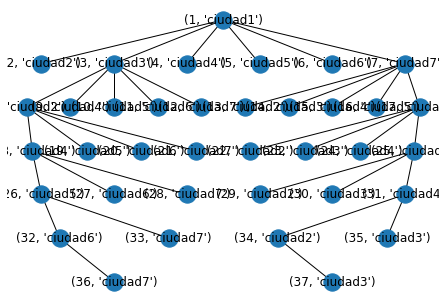

In [3]:
procesar_Aestrella('TSP/TSP_IN_02.txt')

EXITO
La cantidad de nodos abiertos fue de: 26
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (10, 'ciudad6'), (38, 'ciudad3'), (51, 'ciudad4'), (57, 'ciudad5')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad6', 'ciudad3', 'ciudad4', 'ciudad5']
El costo total del óptimo recorrido es de: 31
El tiempo de procesamiento total fue de: 0.039988 segundos


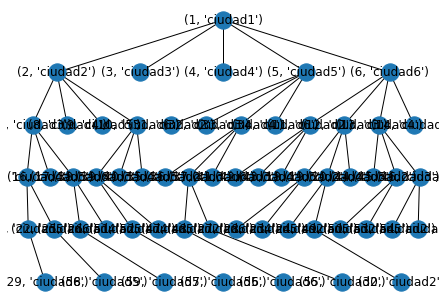

In [4]:
procesar_Aestrella('TSP/TSP_IN_03.txt')

EXITO
La cantidad de nodos abiertos fue de: 207
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (7, 'ciudad3'), (27, 'ciudad4'), (87, 'ciudad5'), (207, 'ciudad6')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6']
El costo total del óptimo recorrido es de: 30
El tiempo de procesamiento total fue de: 1.347602 segundos


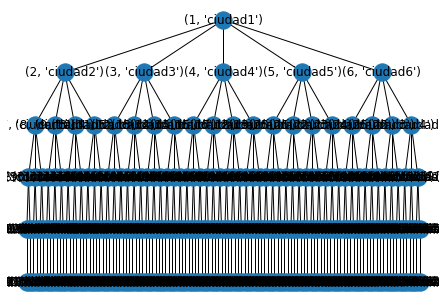

In [5]:
procesar_Aestrella('TSP/TSP_IN_04.txt')

In [7]:
procesar_Aestrella('TSP/TSP_IN_05.txt')

EXITO
La cantidad de nodos abiertos fue de: 410
El óptimo recorrido es: [(1, 'ciudad1'), (9, 'ciudad9'), (16, 'ciudad8'), (518, 'ciudad3'), (530, 'ciudad4'), (696, 'ciudad5'), (716, 'ciudad6'), (1104, 'ciudad2'), (1328, 'ciudad7')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad9', 'ciudad8', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad2', 'ciudad7']
El costo total del óptimo recorrido es de: 78
El tiempo de procesamiento total fue de: 16.747057 segundos


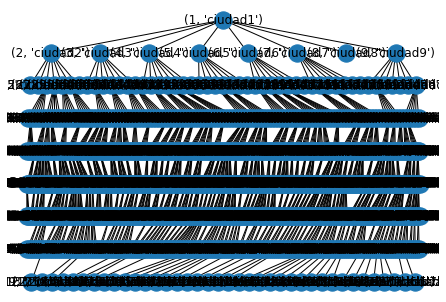

In [6]:
procesar_Aestrella('TSP/TSP_IN_06.txt')

EXITO
La cantidad de nodos abiertos fue de: 18
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (11, 'ciudad3'), (27, 'ciudad4'), (41, 'ciudad5'), (53, 'ciudad6'), (63, 'ciudad7'), (71, 'ciudad8'), (77, 'ciudad9'), (81, 'ciudad10')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7', 'ciudad8', 'ciudad9', 'ciudad10']
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.067977 segundos


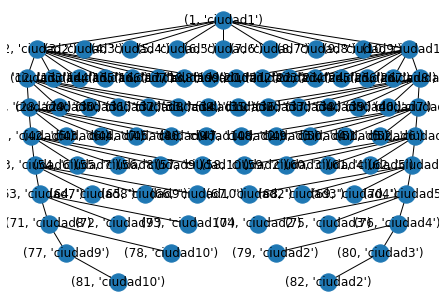

In [7]:
procesar_Aestrella('TSP/TSP_IN_07.txt')

In [13]:
procesar_Aestrella('TSP/TSP_IN_08.txt')

EXITO
La cantidad de nodos abiertos fue de: 18
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (11, 'ciudad3'), (27, 'ciudad4'), (41, 'ciudad5'), (53, 'ciudad6'), (63, 'ciudad7'), (71, 'ciudad8'), (77, 'ciudad9'), (81, 'ciudad10')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad3', 'ciudad4', 'ciudad5', 'ciudad6', 'ciudad7', 'ciudad8', 'ciudad9', 'ciudad10']
El costo total del óptimo recorrido es de: 10
El tiempo de procesamiento total fue de: 0.055985 segundos


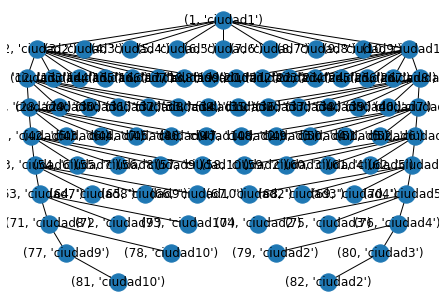

In [8]:
procesar_Aestrella('TSP/TSP_IN_09.txt')

In [9]:
procesar_Aestrella('TSP/TSP_IN_10.txt')

EXITO
La cantidad de nodos abiertos fue de: 28
El óptimo recorrido es: [(1, 'ciudad1'), (2, 'ciudad2'), (17, 'ciudad4'), (44, 'ciudad6'), (69, 'ciudad8'), (92, 'ciudad10'), (113, 'ciudad12'), (132, 'ciudad14'), (148, 'ciudad15'), (156, 'ciudad3'), (168, 'ciudad5'), (178, 'ciudad7'), (186, 'ciudad9'), (192, 'ciudad11'), (196, 'ciudad13')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad2', 'ciudad4', 'ciudad6', 'ciudad8', 'ciudad10', 'ciudad12', 'ciudad14', 'ciudad15', 'ciudad3', 'ciudad5', 'ciudad7', 'ciudad9', 'ciudad11', 'ciudad13']
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.335899 segundos


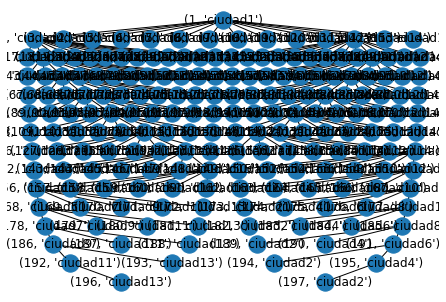

In [3]:
procesar_Aestrella('TSP/TSP_IN_11.txt')

EXITO
La cantidad de nodos abiertos fue de: 28
El óptimo recorrido es: [(1, 'ciudad1'), (5, 'ciudad5'), (23, 'ciudad10'), (53, 'ciudad15'), (66, 'ciudad2'), (90, 'ciudad6'), (113, 'ciudad11'), (126, 'ciudad3'), (143, 'ciudad7'), (159, 'ciudad12'), (168, 'ciudad4'), (178, 'ciudad8'), (187, 'ciudad13'), (192, 'ciudad9'), (196, 'ciudad14')]
O dicho de otro modo el recorrido es: ['ciudad1', 'ciudad5', 'ciudad10', 'ciudad15', 'ciudad2', 'ciudad6', 'ciudad11', 'ciudad3', 'ciudad7', 'ciudad12', 'ciudad4', 'ciudad8', 'ciudad13', 'ciudad9', 'ciudad14']
El costo total del óptimo recorrido es de: 15
El tiempo de procesamiento total fue de: 0.295911 segundos


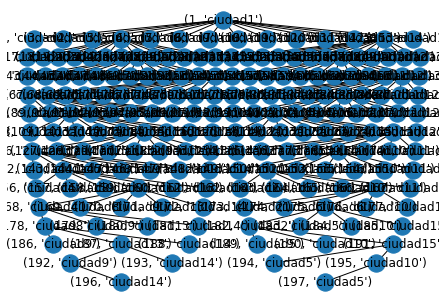

In [4]:
procesar_Aestrella('TSP/TSP_IN_12.txt')